# Desafio TNT

Os desenvolvedores deverão utilizar IBM Watson Studio, e IoT na IBM Cloud para criar um modelo preditivo capaz de alertar momento ideal que será necessária uma nova recarga de uma máquina de venda automática de TNT. Os participantes deverão se conectar a dispositivos IoT para receber os dados de estoque das máquinas em tempo real, e ajudar a empresa na reposição, onde a máquina de venda automática somente será visitada quando houver a necessidade de reabastecimento, poupando gastos desnecessários.

## Instalação de algumas bibliotecas

In [1]:
!pip install scikit-learn --upgrade

Requirement already up-to-date: scikit-learn in c:\python38\lib\site-packages (0.23.2)


In [2]:
!pip install scikit-optimize

In [3]:
!pip install imblearn --upgrade

Requirement already up-to-date: imblearn in c:\python38\lib\site-packages (0.0)


## Lendo os dados do desafio

In [4]:
import pandas as pd
df = pd.read_csv('training.csv')
df.head()

,Tempo,Estacao,LAT,LONG,Movimentacao,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
0,2018-6-26,Luz,-23.5365,-46.6332,127183,65,65,37,23,6,30,38,19,REABASTECER
1,2018-6-27,Luz,-23.5365,-46.6332,126675,57,62,27,22,43,25,34,17,NORMAL
2,2018-6-28,Luz,-23.5365,-46.6332,126995,49,53,17,18,38,22,30,13,NORMAL
3,2018-6-29,Luz,-23.5365,-46.6332,125391,39,44,7,16,35,21,25,9,REABASTECER
4,2018-6-30,Luz,-23.5365,-46.6332,123918,32,40,65,13,32,21,22,3,NORMAL


A figura a seguir mostra graficamente a divisão do TARGET no conjunto de dados, sendo 11518 NORMAL e 5498 REABASTECER, totalizando em 17016 registros. 

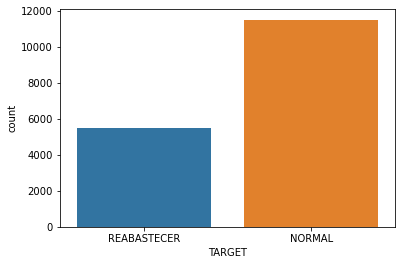

In [5]:
import seaborn as sns
ax = sns.countplot(x=df['TARGET'])

As features escolhidas estão definidas abaixo e representam a quantidade do respectivo produto disponível em determinado local.

In [6]:
features = df[
    [
        'Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina',
       'Citrus', 'Açaí-Guaraná', 'Pêssego'
    ]
]
target = df['TARGET']  ## NÃO TROQUE O NOME DA VARIÁVEL TARGET.

## Divisão do conjunto de dados

Nesta etapa foi feita a divisão dos dados em um conjunto de treinamento (X_train, y_train), teste (X_test, y_test) e validação (X_val,y_val).

In [7]:
from sklearn.model_selection import train_test_split

X, X_val, y, y_val = train_test_split(features, target, test_size=0.2, random_state=133)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=133)


## Balanceamento dos dados de treinamento

Neste passo serão balanceados os dados de treinamento de modo que tenha a mesma quantidade de registros em 'NORMAL' e 'REABASTECER'. Para isso foi utilizado o método SMOTE - Synthetic Minority Over-sampling Technique. 

Mais informações: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#r001eabbe5dd7-1

In [8]:
import imblearn
smote = imblearn.over_sampling.SMOTE()
X_train2, y_train2 = smote.fit_sample(X_train,y_train)

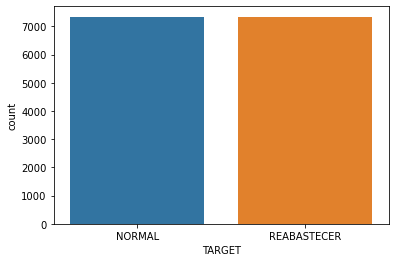

In [9]:
ax = sns.countplot(x=y_train2)

## Estabelecendo o modelo de predição

Após comparações entre diversos modelos, o escolhido foi Random Forest Classifier com hiperparâmetros otimizados. 

In [10]:
from sklearn.ensemble import RandomForestClassifier

### Otimização dos hiperparâmetros do modelo

Para a otimização dos hiperparâmetros do modelo foi utilizado o 'gp_minimize' da biblioteca 'skopt', o qual consiste em uma otimização Bayesiana utilizando processos gaussianos. 

O parâmetro n_calls indica que essa otimização será executada 30 vezes (n_calls=30), sendo 10 vezes randômicas (n_random_starts=10) e as restantes utilizam o conhecimento adquirido nas 10 iterações iniciais. 

Mais informações: https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html

In [11]:
from sklearn.metrics import accuracy_score

def train_model(params):
    min_samples_split = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    n_estimators = params[3]
    
    model = RandomForestClassifier(min_samples_split=min_samples_split,
                          max_depth=max_depth,
                          min_samples_leaf=min_samples_leaf,
                          n_estimators=n_estimators,
                          random_state=42)
    
    model.fit(X_train2,y_train2)
    pred = model.predict(X_test)
    return -accuracy_score(y_test,pred)

In [12]:
params = [(2,200),
          (2,10),
          (1,50),
          (2,150)
]

from skopt import gp_minimize
res = gp_minimize(train_model, params, random_state=42, verbose=1, n_calls=30, n_random_starts=10)
res.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3750
Function value obtained: -0.7539
Current minimum: -0.7539
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2207
Function value obtained: -0.7484
Current minimum: -0.7539
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.7580
Function value obtained: -0.7782
Current minimum: -0.7782
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3158
Function value obtained: -0.7385
Current minimum: -0.7782
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2897
Function value obtained: -0.7393
Current minimum: -0.7782
Iteration No: 6 started. 

[7, 6, 29, 139]

### Declaração do modelo utilizado

In [13]:
rf = RandomForestClassifier(min_samples_split=30,
                          max_depth=7,
                          min_samples_leaf=4,
                          n_estimators=109,
                          random_state=42)

### Testando o modelo no conjunto de teste

In [14]:
from sklearn.metrics import classification_report

In [15]:
rf.fit(X_train2,y_train2)
y_pred = rf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      NORMAL       0.99      0.68      0.81      1861
 REABASTECER       0.59      0.99      0.74       862

    accuracy                           0.78      2723
   macro avg       0.79      0.84      0.77      2723
weighted avg       0.87      0.78      0.79      2723



### Testando o modelo no conjunto de validação

In [16]:
y_pred_val = rf.predict(X_val)
print(classification_report(y_val,y_pred_val))

              precision    recall  f1-score   support

      NORMAL       0.99      0.69      0.82      2316
 REABASTECER       0.60      0.99      0.75      1088

    accuracy                           0.79      3404
   macro avg       0.80      0.84      0.78      3404
weighted avg       0.87      0.79      0.79      3404



### Matriz de confusão

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

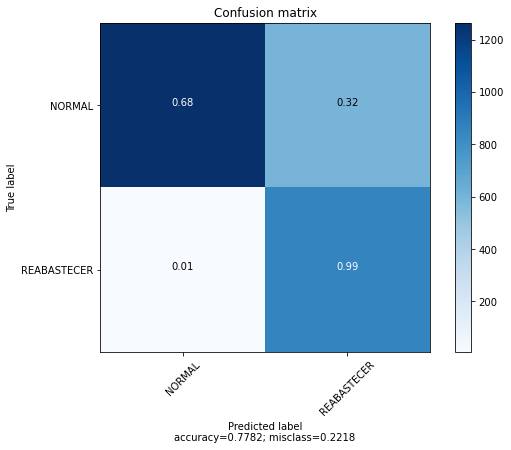

In [18]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['NORMAL', 'REABASTECER'])

# Realizando as predições

In [19]:
df_to_be_scored = pd.read_csv(r'to_be_scored.csv')
df_to_be_scored.tail()

,Tempo,Estação,LAT,LONG,Movimentação,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
979,2019-8-19,Hospital São Paulo,-23.5984,-46.6455,26787,34,65,28,17,33,27,6,2
980,2019-8-20,Hospital São Paulo,-23.5984,-46.6455,26629,21,60,18,15,27,22,43,43
981,2019-8-21,Hospital São Paulo,-23.5984,-46.6455,27517,9,56,13,14,21,17,37,37
982,2019-8-22,Hospital São Paulo,-23.5984,-46.6455,26860,86,49,7,14,17,12,33,33
983,2019-8-23,Hospital São Paulo,-23.5984,-46.6455,24571,74,41,65,8,14,7,27,27


Removendo as colunas que não foram utilizadas no modelo

In [20]:
del df_to_be_scored['Tempo']
del df_to_be_scored['Estação']
del df_to_be_scored['LAT']
del df_to_be_scored['LONG']
del df_to_be_scored['Movimentação']

In [21]:
df_to_be_scored.columns

Index(['Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina',
       'Citrus', 'Açaí-Guaraná', 'Pêssego'],
      dtype='object')

In [22]:
y_pred = rf.predict(df_to_be_scored)
df_to_be_scored['TARGET'] = y_pred
df_to_be_scored.tail()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
979,34,65,28,17,33,27,6,2,REABASTECER
980,21,60,18,15,27,22,43,43,NORMAL
981,9,56,13,14,21,17,37,37,REABASTECER
982,86,49,7,14,17,12,33,33,REABASTECER
983,74,41,65,8,14,7,27,27,NORMAL


# Considerações Finais

Apesar da variação em algumas saídas, os parâmetros definidos no modelo são os mesmos enviados no desafio. Desta forma, o arquivo 'results.csv' presente no repositório não é o mesmo obtido na reexecução deste notebook e sim o arquivo enviado para a resolução do desafio. 

Se este notebook te ajudou de alguma forma, contribua com uma estrela! :D